In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
os.chdir('/content/drive/My Drive/Capstone')
sys.path.insert(0, os.getcwd())

In [3]:
import pandas as pd
from src.train import train_loop, test_loop
from src.model import CNNLSTMModel
from src.dataset_o import InverterTimeSeriesDataset
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [4]:
performe_visualization = True

In [88]:
# some important parameters
pre_day = 3
window_size = 12*24 # 5 minutes * 12 * 24 = 1 day
stride = 12 # 1 hour stride

feature_cols = [
    #"metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    #"metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED"                     # DC voltage
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')] # anomalies in the data
]

## Data Preprocessing
### Load Data

In [89]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [7]:
# if performe_visualization:
#     # Visualize the raw data
#     visualize_hourly_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

### Data Cleaning

In [90]:
print("inverter_data shape:", inverter_data.shape)
filtered_data = exclude_periods_from_data(inverter_data, exclude_periods)
print("Excluded data shape:", filtered_data.shape)

inverter_data shape: (6126272, 59)
Excluded data shape: (5172608, 59)


In [9]:
# remove unused columns
filtered_data = filtered_data[['event_local_time', 'device_name'] + feature_cols]

In [10]:
# if performe_visualization:
#     # Visualize the filtered data
#     visualize_hourly_mean_values(filtered_data, failure_sessions, feature_cols, 'visualization', 'filtered_data')

### Data Labeling

In [91]:
labeled_df = prepare_dataset(filtered_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 38949
Total rows: 5026798


### Missing Value Mask

In [92]:
def generate_missing_value_mask(df: pd.DataFrame, features_cols: list[str]) -> pd.DataFrame:
    # Step 1: 缺失 mask
    for col in features_cols:
        df[f"{col}_missing"] = df[col].isna().astype(int)

generate_missing_value_mask(labeled_df, feature_cols)

In [93]:
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Missing Value Imputation

In [94]:
imputed_df = missing_value_imputation(labeled_df, feature_cols, time_col='event_local_time', device_col='device_name', short_gap_limit=6, long_fill_value=0.0, add_missing_mask=True)

### Feature Engineering

In [95]:
imputed_df['hour_of_day'] = imputed_df['event_local_time'].dt.hour
extended_feature_cols += ['hour_of_day']

In [16]:
# if performe_visualization:
#     visualize_hourly_mean_values(imputed_df, failure_sessions, extended_feature_cols+['label'],
#                                 title='processed_data')

### Split Dataset

In [96]:
train_df, test_df = train_test_split_on_time(imputed_df, 0.3)
val_df, test_df = train_test_split_on_time(test_df, 0.3)

Train set size: 3518759 Train set time range: 2021-12-24 00:00:00 to 2024-08-16 09:30:00
Test set size: 1508039 Test set time range: 2024-08-16 09:30:00 to 2025-07-23 23:35:00
Train set size: 1055628 Train set time range: 2024-08-16 09:30:00 to 2025-04-03 12:30:00
Test set size: 452411 Test set time range: 2025-04-03 12:30:00 to 2025-07-23 23:35:00


### Standardization

In [97]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['hour_of_day']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [19]:
# if performe_visualization:
#     visualize_hourly_mean_values(train_df, failure_sessions, extended_feature_cols+['label'],
#                                  'visualization', 'train_data')
#     visualize_hourly_mean_values(val_df, failure_sessions, extended_feature_cols+['label'],
#                                  'visualization', 'val_data')
#     visualize_hourly_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
#                                     'visualization', 'test_data')

### Create Dataset/Data Loader

In [ ]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset(train_df, extended_feature_cols, under_sample=True, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

In [ ]:
train_ds.X.shape

In [ ]:
# print(len(test_ds.X), len(test_ds.y), test_ds.meta.shape[0])

In [ ]:
pd.value_counts(val_ds.y.numpy()).sort_index()

In [ ]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

In [ ]:
batch_size = 2**8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=6, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)

## Train Model

In [ ]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [99]:
import time

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log = train_loop(
    model, train_loader, val_loader,
    log_interval=10,
    num_epochs=30,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_interval=5,
    save_path='model/0811_1802/',
)

Model moved to cuda
Resuming training from epoch 151
[Epoch 151/30] Step 0/27 - Loss: 0.2103
[Epoch 151/30] Step 10/27 - Loss: 0.2157
[Epoch 151/30] Step 20/27 - Loss: 0.2160
🔁 Epoch 151 finished. Avg Train Loss: 0.2171
✅ Validation Loss: 0.1496 | Accuracy: 68.29%
Best model saved at epoch 151 with loss 0.1496
[Epoch 152/30] Step 0/27 - Loss: 0.2083
[Epoch 152/30] Step 10/27 - Loss: 0.2206
[Epoch 152/30] Step 20/27 - Loss: 0.2151
🔁 Epoch 152 finished. Avg Train Loss: 0.2170
✅ Validation Loss: 0.1491 | Accuracy: 68.43%
Best model saved at epoch 152 with loss 0.1491
[Epoch 153/30] Step 0/27 - Loss: 0.2239
[Epoch 153/30] Step 10/27 - Loss: 0.2093
[Epoch 153/30] Step 20/27 - Loss: 0.2173
🔁 Epoch 153 finished. Avg Train Loss: 0.2173
✅ Validation Loss: 0.1483 | Accuracy: 68.75%
Best model saved at epoch 153 with loss 0.1483
[Epoch 154/30] Step 0/27 - Loss: 0.2349
[Epoch 154/30] Step 10/27 - Loss: 0.2133
[Epoch 154/30] Step 20/27 - Loss: 0.2186
🔁 Epoch 154 finished. Avg Train Loss: 0.2172
✅ V

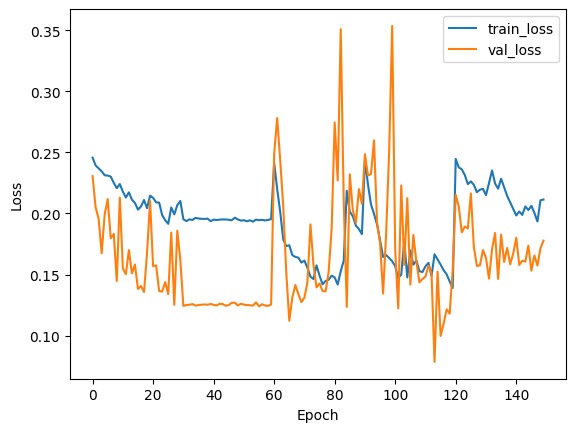

In [29]:
import matplotlib.pyplot as plt
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(model, data_loader):
    trues, predictions, outputs = test_loop(model, data_loader, device='cpu', criterion=criterion)
    print(classification_report(trues, predictions , target_names=['Normal', 'Failure']))
    print(confusion_matrix(trues, predictions ))
    roc_auc = roc_auc_score(trues, outputs)
    print(f"ROC AUC: {roc_auc:.4f}")
    curve = roc_curve(trues, outputs)

    plt.figure(figsize=(8, 6))
    plt.plot(curve[0], curve[1], label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

In [31]:
model = CNNLSTMModel(num_features=len(extended_feature_cols), cnn_out_channels=64, lstm_hidden_size=128)
model.load_state_dict(torch.load(r'model/0811_1802/best_model.pth', weights_only=True))

<All keys matched successfully>

Performance on Training Set:
🔍 Test Loss: 0.2146 | Accuracy: 64.48%
              precision    recall  f1-score   support

      Normal       0.67      0.57      0.62      3445
     Failure       0.63      0.72      0.67      3445

    accuracy                           0.64      6890
   macro avg       0.65      0.64      0.64      6890
weighted avg       0.65      0.64      0.64      6890

[[1971 1474]
 [ 973 2472]]
ROC AUC: 0.7133


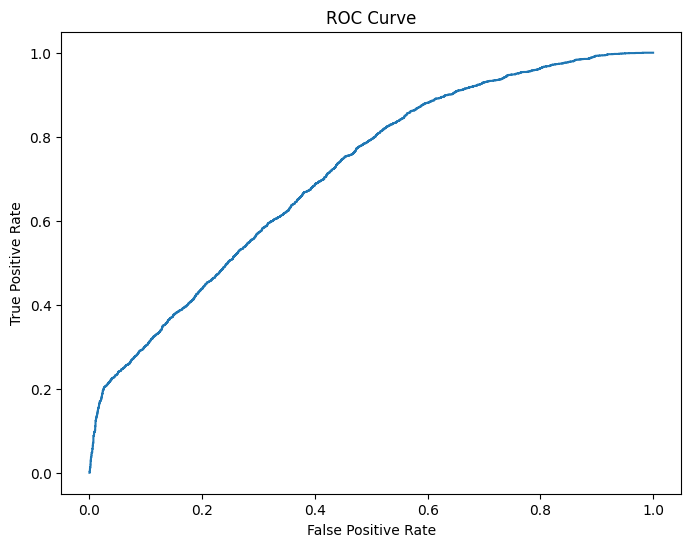

In [32]:
print("Performance on Training Set:")
evaluate_model(model, train_loader)

Performance on Validation Set:
🔍 Test Loss: 0.1465 | Accuracy: 69.53%
              precision    recall  f1-score   support

      Normal       1.00      0.70      0.82     86810
     Failure       0.01      0.63      0.02       360

    accuracy                           0.70     87170
   macro avg       0.50      0.66      0.42     87170
weighted avg       0.99      0.70      0.82     87170

[[60379 26431]
 [  134   226]]
ROC AUC: 0.7350


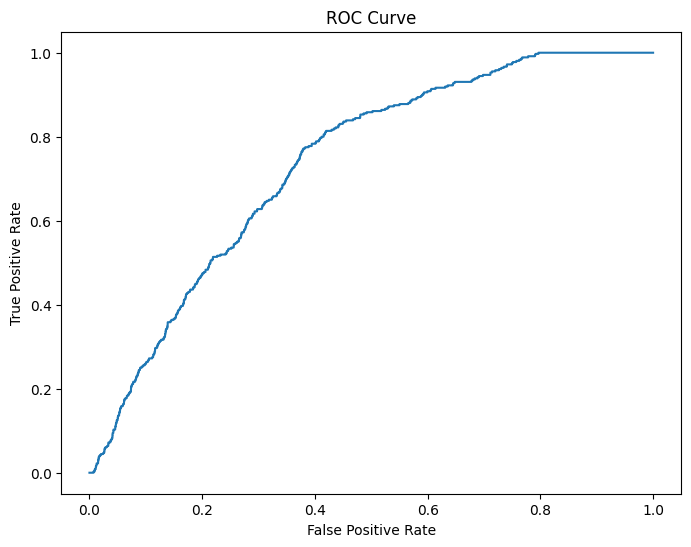

In [33]:
print("Performance on Validation Set:")
evaluate_model(model, val_loader)

Performance on Test Set:
🔍 Test Loss: 0.1727 | Accuracy: 71.74%
              precision    recall  f1-score   support

      Normal       0.97      0.73      0.83     35751
     Failure       0.05      0.35      0.08      1296

    accuracy                           0.72     37047
   macro avg       0.51      0.54      0.46     37047
weighted avg       0.94      0.72      0.81     37047

[[26121  9630]
 [  841   455]]
ROC AUC: 0.5627


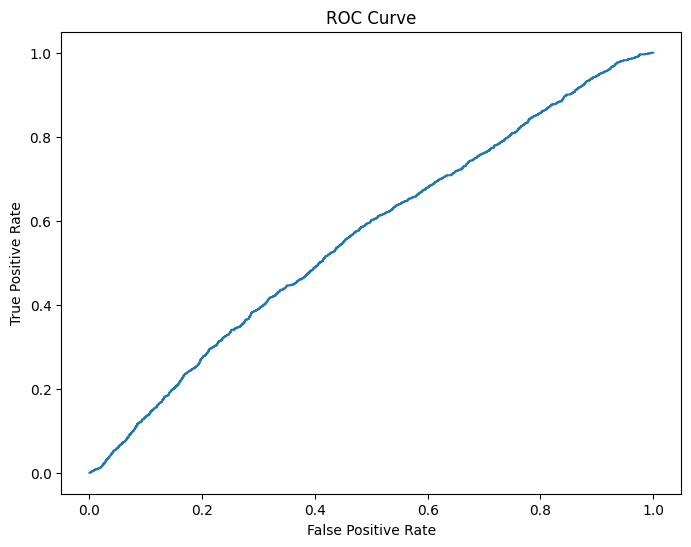

In [34]:
print("Performance on Test Set:")
evaluate_model(model, test_loader)

In [51]:
def reconstruct_meta_like_dataset(df, feature_cols, label_col,
                                  device_col, time_col,
                                  window_size, stride):
    """
    重新建立 meta_df：每個被保留的 window 產生一列 (device_id, score_time)，
    規則要和 InverterTimeSeriesDataset 完全一致。
    """
    import numpy as np
    import pandas as pd

    rows = []
    df = df.sort_values([device_col, time_col]).reset_index(drop=True)

    for dev, g in df.groupby(device_col, sort=False):
        g = g.reset_index(drop=True)
        times  = pd.to_datetime(g[time_col].values)
        feats  = g[feature_cols].to_numpy()
        labels = g[label_col].to_numpy()

        n = len(g)
        if n < window_size:
            continue

        # ---- 依「最常見時間差」切出連續區段（和 Dataset 一致）----
        deltas = pd.Series(times).diff().dt.total_seconds().to_numpy()
        if np.all(np.isnan(deltas)):
            blocks = [(0, n)]
        else:
            expected = pd.Series(deltas[~np.isnan(deltas)]).mode()[0]
            breaks = np.where((~np.isnan(deltas)) & (deltas != expected))[0] + 1
            starts = np.r_[0, breaks]
            ends   = np.r_[breaks, n]
            blocks = list(zip(starts, ends))

        # ---- 在每個連續區段上產生 windows ----
        for s, e in blocks:
            X_blk = feats[s:e]
            y_blk = labels[s:e]
            t_blk = times[s:e]

            m = len(X_blk)
            if m < window_size:
                continue

            for start in range(0, m - window_size + 1, stride):
                end = start + window_size
                y = y_blk[end-1]                 # 用窗尾 label
                if y == -1:                      # 和 Dataset 一樣：跳過 -1
                    continue
                # 若 Dataset 有 NaN 過濾，這裡也要加上：
                # if np.isnan(X_blk[start:end]).any(): continue

                rows.append((dev, t_blk[end-1]))  # score_time = 窗尾時間

    meta_df = pd.DataFrame(rows, columns=["device_id", "score_time"])
    return meta_df


In [52]:
meta_re = reconstruct_meta_like_dataset(
    test_df,
    feature_cols=extended_feature_cols,
    label_col="label",
    device_col="device_name",
    time_col="event_local_time",
    window_size=window_size,
    stride=stride
)

print("重建 meta 行數:", len(meta_re))
print("模型輸出 y_true/y_score 行數:", len(trues), len(probs))  # 你 test_loop 回傳的長度

# 如果還是不一樣，逐條件比較
def count_by_rule(df, feature_cols, label_col, device_col, time_col, window_size, stride):
    import numpy as np, pandas as pd
    kept = 0; kept_after_neg1 = 0
    for dev, g in df.groupby(device_col, sort=False):
        times  = pd.to_datetime(g[time_col].values)
        feats  = g[feature_cols].to_numpy()
        labels = g[label_col].to_numpy()
        n = len(g)
        if n < window_size: continue

        deltas = pd.Series(times).diff().dt.total_seconds().to_numpy()
        if np.all(np.isnan(deltas)):
            blocks = [(0, n)]
        else:
            expected = pd.Series(deltas[~np.isnan(deltas)]).mode()[0]
            breaks = np.where((~np.isnan(deltas)) & (deltas != expected))[0] + 1
            starts = np.r_[0, breaks]
            ends   = np.r_[breaks, n]
            blocks = list(zip(starts, ends))

        for s, e in blocks:
            m = e - s
            if m < window_size: continue
            kept += 1 + (m - window_size) // stride
            # 套 label==-1 過濾
            for st in range(0, m - window_size + 1, stride):
                ed = st + window_size
                if labels[s:e][ed-1] == -1:
                    continue
                kept_after_neg1 += 1
    return kept, kept_after_neg1

c_all, c_after = count_by_rule(test_df, extended_feature_cols, "label",
                               "device_name", "event_local_time",
                               window_size, stride)
print("理論產生 windows（不過濾）:", c_all)
print("套 label==-1 後理論留下:", c_after)
print("重建 meta:", len(meta_re))
print("模型輸出長度:", len(trues))



重建 meta 行數: 37047
模型輸出 y_true/y_score 行數: 37047 37047
理論產生 windows（不過濾）: 37047
套 label==-1 後理論留下: 37047
重建 meta: 37047
模型輸出長度: 37047


In [53]:
trues, preds, probs = test_loop(model, test_loader, device=device, criterion=criterion)

🔍 Test Loss: 0.1727 | Accuracy: 71.74%


In [61]:
import numpy as np
import pandas as pd

def attach_next_event_time(horizon_df: pd.DataFrame,
                           failure_sessions: pd.DataFrame,
                           device_col_left="device_id",
                           time_col_left="score_time",
                           device_col_right="device_name",
                           start_col_right="start_time",
                           end_col_right=None  # 若有 end_time 可用來過濾故障期內資料
                           ) -> pd.DataFrame:
    """
    對每一筆 (device_id, score_time) 指派『該設備的下一個事件時間』作為 event_time。
    若找不到下一個事件，event_time = NaT。
    若提供 end_col_right，並且 score_time 落在 [start,end] 故障期間，可選擇標 NaT 或丟棄。
    """
    df = horizon_df.copy()
    df[time_col_left] = pd.to_datetime(df[time_col_left])
    fs = failure_sessions.copy()
    fs[start_col_right] = pd.to_datetime(fs[start_col_right])
    if end_col_right and end_col_right in fs.columns:
        fs[end_col_right] = pd.to_datetime(fs[end_col_right])

    out = []
    for dev, g in df.groupby(device_col_left, sort=False):
        gg = g.sort_values(time_col_left).copy()
        starts = fs.loc[fs[device_col_right] == dev, start_col_right]\
                   .sort_values().to_numpy(dtype="datetime64[ns]")

        if len(starts) == 0:
            gg["event_time"] = pd.NaT
            out.append(gg)
            continue

        t = gg[time_col_left].to_numpy(dtype="datetime64[ns]")
        idx = np.searchsorted(starts, t, side="left")  # 下一個事件的索引

        ev = np.full(len(gg), np.datetime64("NaT"), dtype="datetime64[ns]")
        valid = idx < len(starts)
        ev[valid] = starts[idx[valid]]
        gg["event_time"] = ev

        # 如果你想把『已在故障期間內』的分數排除，可用 end_time 過濾（可選）
        if end_col_right and end_col_right in fs.columns:
            # 找到「上一個事件」的 end_time，若 score_time <= end_time 表示在故障期間
            ends_for_dev = fs.loc[fs[device_col_right] == dev, end_col_right]\
                              .sort_values().to_numpy(dtype="datetime64[ns]")
            prev_idx = idx - 1
            in_fail = (prev_idx >= 0) & (t <= ends_for_dev[prev_idx.clip(min=0)])
            gg.loc[in_fail, "event_time"] = np.datetime64("NaT")  # 或者 gg = gg[~in_fail]

        out.append(gg)

    return pd.concat(out, ignore_index=True)


In [62]:
# 先把 y_true / y_score 塞回 meta_re（或 dataset.meta）
horizon_df = meta_re.copy()
horizon_df["y_true"]  = trues
horizon_df["y_score"] = probs

# 正確指派「下一個事件時間」
horizon_df = attach_next_event_time(
    horizon_df,
    failure_sessions,
    device_col_left="device_id",
    time_col_left="score_time",
    device_col_right="device_name",
    start_col_right="start_time",
    end_col_right="end_time"  # 若沒有可傳 None
)

# 檢查：score_time 應該都早於（或等於）對到的 event_time；沒事件的會是 NaT
bad = horizon_df.dropna(subset=["event_time"])
print("有誤筆數：", (bad["score_time"] > bad["event_time"]).sum())


有誤筆數： 0


In [63]:
horizon_df.head()

,device_id,score_time,y_true,y_score,event_time
0,INV 51,2025-04-04 12:30:00,0.0,0.144426,2025-04-20 13:35:00
1,INV 51,2025-04-04 13:30:00,0.0,0.132745,2025-04-20 13:35:00
2,INV 51,2025-04-04 14:30:00,0.0,0.143192,2025-04-20 13:35:00
3,INV 51,2025-04-04 15:30:00,0.0,0.142988,2025-04-20 13:35:00
4,INV 51,2025-04-04 16:30:00,0.0,0.147586,2025-04-20 13:35:00


In [82]:
import pandas as pd
import numpy as np

def horizon_recall(horizon_df, tau, horizons_days):
    """
    計算不同 horizon (提前天數) 下的 Recall。

    參數：
    - horizon_df: DataFrame，包含 device_id, score_time, y_score, event_time
    - tau: float，分數門檻（機率閾值）
    - horizons_days: list[int]，要計算的提前天數

    回傳：
    - DataFrame: 每個 horizon 對應的 Recall
    """
    results = []

    # 確保時間型態正確
    df = horizon_df.copy()
    df["score_time"] = pd.to_datetime(df["score_time"])
    df["event_time"] = pd.to_datetime(df["event_time"])

    # 逐個 horizon 計算
    for H in horizons_days:
        # 儲存有被提前 H 天偵測到的 event
        detected_events = set()

        for dev, grp in df.groupby("device_id"):
            # 該設備的事件時間
            event_time = grp["event_time"].iloc[0]  # 假設每台機器只有一個 failure_event
            # 篩選出符合提前 H 天條件 & 機率 >= tau 的預測
            alerts = grp[
                (grp["y_score"] >= tau) &
                (grp["score_time"] <= event_time - pd.Timedelta(days=H))
            ]
            if not alerts.empty:
                detected_events.add((dev, event_time))

        # 計算 recall
        total_events = df[["device_id", "event_time"]].drop_duplicates().shape[0]
        recall = len(detected_events) / total_events if total_events > 0 else np.nan
        results.append({"H_days": H, "Recall": recall})

    return pd.DataFrame(results)


def plot_horizon_recall(horizon_df, tau, horizons_days=(30, 45, 60, 75, 90)):
    hr = horizon_recall(horizon_df, tau, horizons_days)
    plt.figure()
    plt.plot(hr["H_days"], hr["Recall"], marker='o')
    plt.xlabel("H (days)"); plt.ylabel("Recall")
    plt.title(f"Horizon–Recall @ τ={tau:.2f}")
    plt.grid(True); plt.show()
    return hr

In [79]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# def horizon_recall_monotone(horizon_df: pd.DataFrame,
#                             tau: float,
#                             horizons_days=(15,30,45,60,75,90)) -> pd.DataFrame:
#     df = horizon_df.copy()
#     df["score_time"] = pd.to_datetime(df["score_time"])
#     df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")

#     # 建事件清單（每個 (device_id, event_time) 一次）
#     events = df.dropna(subset=["event_time"])[["device_id","event_time"]].drop_duplicates()

#     # 對每個事件，找出「最早命中的時間距離（天）」
#     min_lead_days = []
#     for dev, t_event in events.itertuples(index=False):
#         sub = df[df["device_id"] == dev]
#         if sub.empty:
#             min_lead_days.append(np.inf)
#             continue
#         lead = (t_event - sub["score_time"]).dt.total_seconds() / 86400.0
#         # 只看事件前（lead >= 0）且分數達門檻的點
#         hit_lead = lead[(lead >= 0) & (sub["y_score"] >= tau)]
#         m = hit_lead.min() if not hit_lead.empty else np.inf
#         min_lead_days.append(m)

#     min_lead_days = np.array(min_lead_days, dtype=float)
#     n_events = len(min_lead_days)

#     results = []
#     for H in horizons_days:
#         hit = np.sum(min_lead_days <= H)
#         results.append({
#             "H_days": H,
#             "Recall": hit / max(n_events, 1),
#             "n_events": n_events,
#             "n_alerted": int(hit),
#             "tau": tau
#         })
#     return pd.DataFrame(results)

# def plot_horizon_recall(horizon_df, tau, horizons_days=(15,30,45,60,75,90)):
#     hr = horizon_recall_monotone(horizon_df, tau, horizons_days)
#     plt.figure()
#     plt.plot(hr["H_days"], hr["Recall"], marker="o")
#     plt.ylim(0, 1)
#     plt.xlabel("H (days)")
#     plt.ylabel("Recall")
#     plt.title(f"Horizon-Recall @ τ={tau:.2f}")
#     plt.grid(True)
#     plt.show()
#     return hr


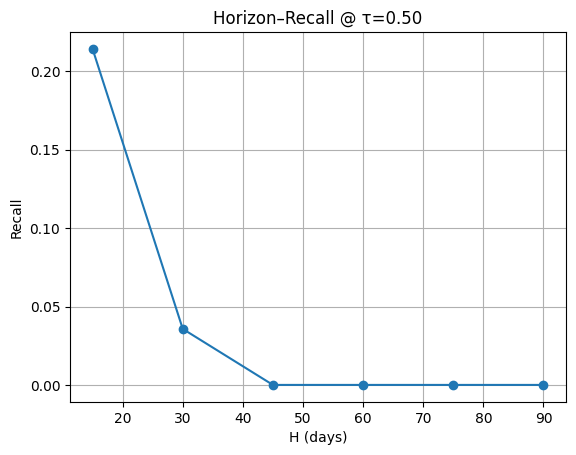

KeyError: "['n_events', 'n_alerted'] not in index"

In [83]:
# hr = plot_horizon_recall(horizon_df, tau=0.50, horizons_days=[15,30,45,60,75,90])
# print(hr[["H_days","n_events","n_alerted","Recall"]])
# print(np.diff(hr["Recall"].to_numpy()))  # 應全 >= 0


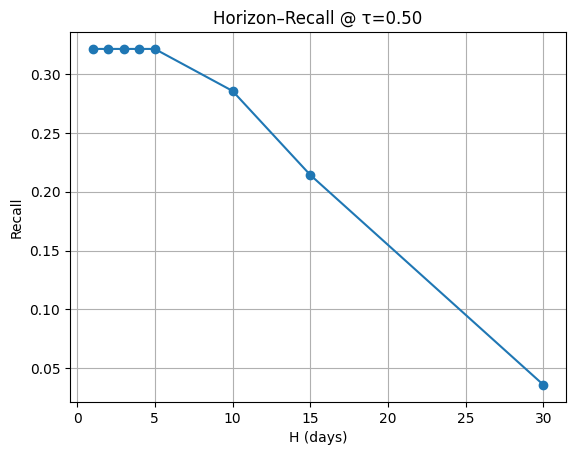

   H_days    Recall
0       1  0.321429
1       2  0.321429
2       3  0.321429
3       4  0.321429
4       5  0.321429
5      10  0.285714
6      15  0.214286
7      30  0.035714


In [87]:
# tau 門檻
tau = 0.5
# 掃描不同 H
horizons_days = [1, 2, 3, 4, 5, 10, 15, 30]

# horizon_df 需要符合 horizon_recall 的輸入需求

recall_results = plot_horizon_recall(
    horizon_df,
    tau=tau,
    horizons_days=horizons_days
)

print(recall_results)
